<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2010%20-CNN%20Applications%20and%20Tricks/Lecture_10_CNN_Applications_and_Tricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning & Convolutional Neural Networks



In [ ]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from sklearn import metrics


In [ ]:
#Auxiliary Function to plot images side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)
    
  for i in range(n):         
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

#Plot dataset samples
def plot_dataset(ds, lbls_name):
  N_SAMPLES = 10
  for i in range(5):
    for x,y in ds.take(1):    
      
      x = x.numpy()
      x = np.squeeze(x)      
      y = y.numpy()
      plot_sidebyside(x[:N_SAMPLES],
                      y[:N_SAMPLES],'gray')

#Plot a training history
def plot_history(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


# Datasets

In [ ]:
def load_dataset(name='mnist'):  
  if name == 'mnist':
    lbls_name = ['0','1','2','3','4',
                 '5','6','7','8','9']
  elif name == 'fashion_mnist':
    lbls_name = ['T-shirt/top','Trouser','Pullover','Dress',
                 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
  elif name == 'cifar10':
    lbls_name = ['airplane','automobile','bird','cat','deer',
                 'dog','frog','horse','ship','truck']
  
  ds_train = tfds.load(name, split='train[:75%]', shuffle_files=True) 
  ds_val = tfds.load(name, split='train[75%:]', shuffle_files=True) 
  ds_test = tfds.load(name, split='test', shuffle_files=True) 

  return ds_train,ds_val,ds_test,lbls_name

#The Convolutional Layers
  As stated in the last class, a cnn model enqueue several convolutional layers. This step is called 'feature extraction'. In the end of this structure, the resulting matrix is a feature map with dense representations

  Lets see how to code it!

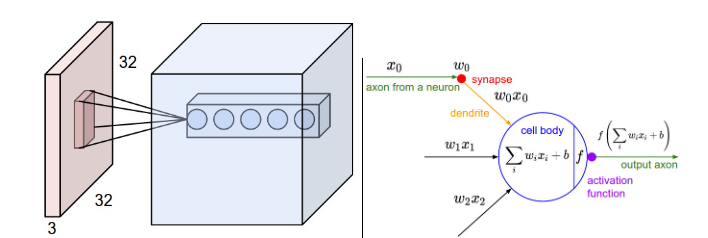


Additional Reference: https://cs231n.github.io/convolutional-networks/

In [ ]:
model = models.Sequential()

#32 layers of size 3x3 and Relu Activation
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
#Max Pooling of Size (2x2)
model.add(layers.MaxPooling2D((2, 2)))


#64 layers of size 3x3 and Relu Activation
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#Max Pooling of Size (2x2)
model.add(layers.MaxPooling2D((2, 2)))

#64 layers of size 3x3 and Relu Activation
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

#The Fully Connected Layer
  The fully connected layer (FC) is a dense layer that receives a 1D tensor. It will provide predictions and probabilities. This is the classification step in the pipeline and can be replaced for another model. (SVM, etc.)

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

model.summary()

#Training

In [ ]:
def ds_preprocess(sample, input_size=(32,32,1), norm=1.):

    image = sample['image']
    label = sample['label']
    image = tf.cast(image, tf.float32)
    
    # Normalize the pixel values (0...1)
    image = image / norm
    
    # Resize the image
    image = tf.image.resize(image, input_size,method='nearest')    
    return image, label

In [ ]:
def ds_set_parameters(ds, input_size=(32,32),norm=255.,shuffle=True,
                      batch_size=16,buffer_size=256,
                      process_function=ds_preprocess):
  

  if (shuffle):
    ds = ds.shuffle(buffer_size=buffer_size)

  ds = ds.batch(batch_size).prefetch(1)

  ds = ds.map(lambda x : 
                process_function(x,input_size,norm=norm))

  #ds = ds.cache()
  
 
  
  return ds

In [ ]:
from sklearn.utils import shuffle

seed_number = 10
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

input_shape_ = (32,32,3)
batch_size_ = 32
epochs_ = 10
N_CLASSES = 10
dataset_name = 'cifar10' #'mnist','fashion_mnist','cifar10'
model_name = 'Lenet' #Lenet, 'Alexnet', 'VGG16'

#Load TFDS dataset
ds_train, ds_val, ds_test, lbls_name = load_dataset(dataset_name)


#Setting up
ds_train = ds_set_parameters(ds_train,input_shape_[:2],norm=norm_,
                             batch_size=batch_size_, buffer_size=batch_size_,
                             process_function=ds_preprocess)

#Setting up
ds_val = ds_set_parameters(ds_val,input_shape_[:2],norm=norm_,
                             batch_size=batch_size_, buffer_size=256,
                             process_function=ds_preprocess)

#Plot samples
plot_dataset(ds_train,lbls_name)



model.summary()
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(ds_train, batch_size=batch_size_, epochs=epochs_, validation_data=ds_val)



In [ ]:
plot_history(history)

##Evaluation



In [ ]:
def performance_evaluation(y_test, predictions,info_message,figsize=(18, 4)):
  
  print(f"Evaluation of ", info_message)
  print(f"{metrics.classification_report(y_test, predictions)}\n")
  print(lbls_name)
  disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
  disp.figure_.suptitle("Confusion Matrix")
  plt.show()
  



In [ ]:
_,_,ds_test, lbls_name = load_dataset(dataset_name)
ds_test = ds_set_parameters(ds_test,input_shape_[:2],norm=norm_,
                             batch_size=batch_size_, buffer_size=256,
                             process_function=ds_preprocess,shuffle=False)

predictions = model.predict(ds_test)
y_test = tf.concat([y for x, y in ds_test], axis=0)
predictions = np.argmax(predictions,axis=1)
performance_evaluation(y_test,predictions,'Lenet')

##Visualizing Learned Filters and Feature Maps

In [ ]:
for i in range(len(model.layers[1:])):    
    layer = model.layers[i+1]
    if 'conv' not in layer.name:
        continue 

    filters , _ = layer.get_weights()
    
    print(f'### {layer.name} - {filters.shape} ###')
        
    #minmax normalization 
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    
    n_filters = 6
    
    ix=1
    fig = plt.figure(figsize=(6,6))
    
    for i in range(n_filters):        
        f = filters[:,:,:,i]        
        for j in range(6):            
            plt.subplot(n_filters,6,ix)
            plt.imshow(f[:,:,j] ,cmap='gray')
            plt.axis('off')
            ix+=1

    #plot the filters 
    plt.show()
    print('-----------------')

In [ ]:
for x,y in ds_test.take(1):
  x_test = x.numpy()

for i in range(len(model.layers[1:])):
    
    layer = model.layers[i+1]

    if 'conv' not in layer.name:
        continue 

    filters , _ = layer.get_weights()
   
    print(f'### {layer.name} - {filters.shape} ###')
    model_ = Model(inputs=model.inputs , outputs=model.layers[i].output)
    features = model_.predict(x_test[3:4])
    fig = plt.figure(figsize=(20,15))
    for i in range(1,features.shape[3]+1):

        plt.subplot(8,8,i)
        plt.imshow(features[0,:,:,i-1] , cmap='gray')
        
    plt.show()

#Pratice 01:
  Now it's up to you. Try the other datasets and architectures available in this notebook. The rationale here is to understand the CNN background, different challenges, and deep networks

#Pratice 02:
  Evaluate the Simpsons dataset [https://bit.ly/3yQnFKA]
* Does CNN correctly recognize?
* Try to guess what is happening? Overfitting? Few Samples? Imbalanced Classes?
* How can we approach this dataset correctly?



